In [1]:
import pandas as pd
import requests
import io
import numpy as np
import os
#import psycopg2
from tqdm import tqdm_notebook
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.lines import Line2D
import plotly.graph_objects as go
import seaborn as sns
from scipy import stats, signal
import sympy as sym

# linear regression
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, roc_curve, precision_recall_curve, plot_precision_recall_curve, plot_roc_curve

# facebook prophet
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import add_changepoints_to_plot, plot_cross_validation_metric

# for seeing more
pd.set_option('max_rows', 100)
pd.set_option('max_columns', 100)

# get scrolling plot
from IPython.core.display import HTML
style = """
<style>
div.output_area {
    overflow-y: scroll;
}
div.output_area img {
    max-width: unset;
}
</style>
"""
HTML(style) 

In [2]:
# various functions

def plot_dayofweek_target(target):
    '''
    Create a day of week plot of target to look for seasonality
    '''
    n_colors = dix.index.dayofweek.nunique()
    colors = sns.color_palette("Set2")[:n_colors]
    cmap = dict(zip(dix.index.dayofweek.unique(), colors))
    n_to_day = {}
    zip_days = zip(dix.index.dayofweek, dix.index.day_name())

    while len(n_to_day) < n_colors:
        tup = next(zip_days)
        if tup[0] not in n_to_day:
            n_to_day[tup[0]] = tup[1]

    named_cmap = {}
    # sns.palplot(colors)

    # look for any kind of seasonalities
    fig, ax = plt.subplots(1,1, figsize=(len(dix)//20,10))
    ax.scatter(dix.index, dix[target], c = dix.index.dayofweek.map(lambda x: cmap[x]))
    # setup legend
    custom_legend = []
    custom_label = []
    for n, day in n_to_day.items():
        custom_legend.append(Line2D([0], [0], color=cmap[n], lw = 4))
        custom_label.append(day)

    ax.legend(custom_legend, custom_label, loc='upper left')
    
def plot_cols_compare(cols):
    fig, ax = plt.subplots(1,1, figsize=(len(dix)//20,10))

    pars_list = []
    lns = []
    color = iter(cm.rainbow(np.linspace(0,1,dix.shape[1])))
    for i, col in enumerate(cols):
        c_min, c_max = dix[col].min(), dix[col].max()
        c = next(color)
        if i == 0:
            ax.set_ylim(c_min, c_max)
            ax.set_ylabel(f"{col}")
            ax.set_xlabel('date')
            p = ax.plot(dix.index, dix[col], label = f"{col}", color=c)[0]
            ax.yaxis.label.set_color(p.get_color())
        else:
            par = ax.twinx()
            par.set_ylim(c_min, c_max)
            par.set_ylabel(f"{col}")
    #         direction = 'right'
    #         offset = i*70
            if i <= 2: 
                direction = 'left'
                offset = i*60
            else: 
                direction = 'right'
                offset = (i-2)*60 
            par.yaxis.set_ticks_position(direction)
            par.yaxis.set_label_position(direction)
            par.spines[direction].set_position(('outward', offset))
            p = par.plot(dix.index, dix[col], label = f"{col}", color=c, linestyle = '-.')[0]
            par.yaxis.label.set_color(p.get_color())
        lns.append(p)

    ax.legend(handles=lns, loc='upper left')
    ax.set_title(f"Graphs of {', '.join(cols)}")    

# Motivations

In [3]:
'''
We were interested in the current state of the stock markets and wanted
to have a project to examine stocks.

Justin came across two indices and a whitepaper published by squeezemetrics.
They claim that Gex is related to the variability in the next day's returns.
Justin wanted to investigate that claim as well as try initial steps at building
a predictive model using their indices.

Dennis causually paid attention to stocks on a daily basis. What he felt intriguing is the SARIMA time series analysis and FB prophet that he always wanted to put in practice. There comes an opportunity with Justin to partner a full blown time series analysis on the best time series data out there, which is the equity markets.
'''

"\nWe were interested in the current state of the stock markets and wanted\nto have a project to examine stocks.\n\nJustin came across two indices and a whitepaper published by squeezemetrics.\nThey claim that Gex is related to the variability in the next day's returns.\nJustin wanted to investigate that claim as well as try initial steps at building\na predictive model using their indices.\n"

# Data Sources

In [ ]:
'''
Justin sourced data directly from a csv-link download from squeezemetrics.
He added various other potentially useful indicators/signals derived from
the 3 features of price, Dix, and Gex. Examples include calculating returns
and transforming to log returns, as well as creating various binary indicators
conjectured to potentially be useful.


'''

# Justin

## Load in data and data prep

In [4]:
dix_url = 'https://squeezemetrics.com/monitor/static/DIX.csv'
dix = pd.read_csv(dix_url, parse_dates=[0])
dix = dix.set_index('date')
# dix.columns = ['price', 'dix', 'gex']

# work with normalized gex
# dix.gex = (dix.gex - dix.gex.mean())/dix.gex.std()

# Add some extra features
dix['dix_1d_pct_chg'] = (dix.dix - dix.dix.shift())/dix.dix.shift() * 100
dix['gex_1d_pct_chg'] = (dix.gex - dix.gex.shift())/dix.gex.shift() * 100
dix['gamma_sign'] = np.sign(dix.gex)
dix['gamma_flipped'] = np.where(dix.gamma_sign != dix.gamma_sign.shift(), 1, 0)
dix['dix_gte_.4'] = np.where(dix.dix >= .4, 1, 0)
dix['sma_20'] = dix.price.rolling(window=20).mean()
# do ema here
dix['ema_20'] = dix['price'].ewm(span=20).mean()
# dix['gex_1d_pct_chg'] = abs((dix.gex - dix.gex.shift())/dix.gex.shift() * 100) * np.sign(dix.gex - dix.gex.shift())
# Add various forms of knowable returns (t - 1), simple and log
dix['simple_ret'] = (dix.price - dix.price.shift())/dix.price.shift()
dix['log_ret'] = np.log(1 + dix.simple_ret)

# try detrending price, dix, gex
dix['detr_price'] = signal.detrend(dix['price'])
dix['detr_dix'] = signal.detrend(dix['dix'])
dix['detr_gex'] = signal.detrend(dix['gex'])
dix['tmr_price'] = dix.price.shift(-1)
dix['tmr_detr_price'] = dix.detr_price.shift(-1)
dix['tmr_simple_ret'] = dix.simple_ret.shift(-1)
dix['tmr_log_ret'] = dix.log_ret.shift(-1)
dix['tmr_r_or_g'] = np.sign(dix.tmr_simple_ret)
dix = dix.query('tmr_r_or_g != 0')
ori_dix = dix.copy()


# alternative calculation for log_ret
#dix['log_ret_2'] = np.log(dix.price) - np.log(dix.price.shift())

# add column for simple rules
# dix['trade_signal'] = np.where(dix['dix_gte_.4'] < 1 & dix.gamma_sign < 0, 'sell',#                               )
# sell signal
                               


#dix['tmr_price'] = dix.price.shift(-1)
dix.query('date >= "2020-02-01"')

price       dix           gex  dix_1d_pct_chg  gex_1d_pct_chg  \
date                                                                          
2020-02-03  3248.92  0.408136  1.886169e+09       -3.870546       22.003078   
2020-02-04  3297.59  0.389276  3.359119e+09       -4.620988       78.092191   
2020-02-05  3334.69  0.410363  4.067938e+09        5.417078       21.101346   
2020-02-06  3345.78  0.418595  5.336331e+09        2.005961       31.180224   
2020-02-07  3327.70  0.430928  4.120952e+09        2.946293      -22.775549   
2020-02-10  3352.10  0.409942  5.361524e+09       -4.869939       30.104005   
2020-02-11  3357.75  0.424073  5.722247e+09        3.447198        6.727993   
2020-02-12  3379.45  0.408969  7.967208e+09       -3.561717       39.232172   
2020-02-13  3373.94  0.423863  7.211357e+09        3.641774       -9.487025   
2020-02-14  3380.14  0.432182  5.770086e+09        1.962568      -19.986126   
2020-02-18  3370.29  0.408374  5.660220e+09       -5.508592       -1.904063   
2020-02-19  3386.12  0.416881  6.381535e+09        2.083068       12.743590   
2020-02-20  3373.23  0.425312  4.437307e+09        2.022403      -30.466471   
2020-02-21  3337.68  0.420910  1.322774e+09       -1.035017      -70.189700   
2020-02-24  3225.89  0.381211 -7.732334e+08       -9.431756     -158.455422   
2020-02-25  3128.27  0.393859 -1.631927e+09        3.317803      111.052351   
2020-02-26  3116.43  0.398890 -1.624170e+09        1.277482       -0.475363   
2020-02-27  2978.56  0.361878 -2.958423e+09       -9.278808       82.149869   
2020-02-28  2954.21  0.380413 -1.423445e+09        5.121999      -51.884989   
2020-03-02  3090.26  0.448496 -1.320902e+08       17.896959      -90.720387   
2020-03-03  3003.37  0.456905 -1.094765e+09        1.875032      728.800633   
2020-03-04  3130.12  0.420300  1.292494e+09       -8.011477     -218.061359   
2020-03-05  3024.08  0.442533 -9.922481e+08        5.289679     -176.770028   
2020-03-06  2972.40  0.452162 -1.026985e+09        2.175873        3.500815   
2020-03-09  2746.52  0.416465 -1.664364e+09       -7.894710       62.063184   
2020-03-10  2882.24  0.418250 -1.000251e+09        0.428566      -39.901911   
2020-03-11  2741.38  0.439415 -1.628877e+09        5.060355       62.846768   
2020-03-12  2480.64  0.377596 -2.170934e+09      -14.068316       33.277995   
2020-03-13  2710.94  0.390936 -1.540240e+09        3.532715      -29.051723   
2020-03-16  2386.13  0.372537 -1.758235e+09       -4.706319       14.153294   
2020-03-17  2529.09  0.352458 -1.153920e+09       -5.389934      -34.370534   
2020-03-18  2398.42  0.354209 -2.314059e+08        0.496940      -79.946109   
2020-03-19  2409.53  0.353335 -1.009988e+09       -0.246892      336.457452   
2020-03-20  2304.88  0.411404 -6.417786e+08       16.434618      -36.456840   
2020-03-23  2237.40  0.366571 -6.780356e+07      -10.897479      -89.435054   
2020-03-24  2447.33  0.402208  6.002200e+08        9.721616     -985.233743   
2020-03-25  2475.56  0.461185 -1.576467e+08       14.663409     -126.264814   
2020-03-26  2630.07  0.480941  1.106730e+09        4.283710     -802.031748   
2020-03-27  2541.47  0.482826 -2.893855e+08        0.391867     -126.147804   
2020-03-30  2626.65  0.472740  9.862025e+07       -2.088889     -134.079196   
2020-03-31  2584.59  0.497417 -1.482108e+08        5.219901     -250.284378   
2020-04-01  2470.50  0.511401 -7.728500e+08        2.811427      421.453116   
2020-04-02  2526.90  0.485221 -5.073984e+08       -5.119195      -34.347100   
2020-04-03  2488.65  0.506475 -4.630797e+08        4.380204       -8.734504   
2020-04-06  2663.68  0.446698  1.555165e+09      -11.802562     -435.830864   
2020-04-07  2659.41  0.482110  1.533925e+09        7.927541       -1.365737   
2020-04-08  2749.98  0.501114  3.331833e+09        3.941869      117.209611   
2020-04-09  2789.82  0.488574  2.608413e+09       -2.502467      -21.712376   
2020-04-13  2761.63  0.493960  3.422978e+09        1.102277     

In [5]:
dix.tail()

price       dix           gex  dix_1d_pct_chg  gex_1d_pct_chg  \
date                                                                          
2020-05-04  2842.74  0.463197  1.434456e+09       -4.113405       98.875826   
2020-05-05  2868.44  0.454598  1.599407e+09       -1.856374       11.499233   
2020-05-06  2848.42  0.473474  2.848290e+09        4.152170       78.084076   
2020-05-07  2881.19  0.457291  5.535218e+09       -3.417921       94.334796   
2020-05-08  2929.80  0.440817  3.754598e+09       -3.602571      -32.168919   

            gamma_sign  gamma_flipped  dix_gte_.4     sma_20       ema_20  \
date                                                                        
2020-05-04         1.0              0           1  2809.4440  2804.035127   
2020-05-05         1.0              0           1  2819.6820  2810.168925   
2020-05-06         1.0              0           1  2829.1325  2813.811884   
2020-05-07         1.0              0           1  2835.6930  2820.228848   
2020-05-08         1.0              0           1  2842.6920  2830.664195   

            simple_ret   log_ret  detr_price  detr_dix      detr_gex  \
date                                                                   
2020-05-04    0.004250  0.004241 -217.423515  0.042913 -1.431437e+09   
2020-05-05    0.009041  0.009000 -192.557741  0.034314 -1.267088e+09   
2020-05-06   -0.006979 -0.007004 -213.411967  0.053190 -1.880792e+07   
2020-05-07    0.011505  0.011439 -181.476193  0.037006  2.667518e+09   
2020-05-08    0.016872  0.016731 -133.700419  0.020532  8.862954e+08   

            tmr_price  tmr_detr_price  tmr_simple_ret  tmr_log_ret  tmr_r_or_g  
date                                                                            
2020-05-04    2868.44     -192.557741        0.009041     0.009000         1.0  
2020-05-05    2848.42     -213.411967       -0.006979    -0.007004        -1.0  
2020-05-06    2881.19     -181.476193        0.011505     0.011439         1.0  
2020-05-07    2929.80     -133.700419        0.016872     0.016731         1.0  
2020-05-08        NaN             NaN             NaN          NaN         NaN

In [6]:
dix.corr()

price       dix       gex  dix_1d_pct_chg  gex_1d_pct_chg  \
price           1.000000 -0.090020  0.354014       -0.004007       -0.001885   
dix            -0.090020  1.000000 -0.265246        0.351723       -0.014471   
gex             0.354014 -0.265246  1.000000       -0.018078       -0.012229   
dix_1d_pct_chg -0.004007  0.351723 -0.018078        1.000000        0.054239   
gex_1d_pct_chg -0.001885 -0.014471 -0.012229        0.054239        1.000000   
gamma_sign      0.003131 -0.129667  0.505752       -0.027738        0.008460   
gamma_flipped   0.025426  0.101956 -0.282052        0.011835       -0.009265   
dix_gte_.4      0.005670  0.706623 -0.147535        0.275293        0.011108   
sma_20          0.994755 -0.099114  0.289478        0.000412       -0.001653   
ema_20          0.996407 -0.086052  0.300131       -0.000545       -0.001613   
simple_ret      0.017738 -0.111240  0.243575       -0.217510        0.024279   
log_ret         0.017410 -0.111482  0.248668       -0.216246        0.024191   
detr_price      0.217040 -0.442713  0.544925       -0.014858        0.005190   
detr_dix       -0.096194  0.999980 -0.266779        0.351732       -0.014452   
detr_gex        0.121684 -0.274873  0.970354       -0.018429       -0.011834   
tmr_price       0.999021 -0.088480  0.353573       -0.003458       -0.001085   
tmr_detr_price  0.213739 -0.433125  0.545613       -0.015045        0.008812   
tmr_simple_ret -0.024798  0.049525 -0.018809        0.007413        0.019521   
tmr_log_ret    -0.025165  0.048270 -0.012724        0.007421        0.019452   
tmr_r_or_g     -0.000701  0.023085 -0.021584        0.024627        0.018895   

                gamma_sign  gamma_flipped  dix_gte_.4    sma_20    ema_20  \
price             0.003131       0.025426    0.005670  0.994755  0.996407   
dix              -0.129667       0.101956    0.706623 -0.099114 -0.086052   
gex               0.505752      -0.282052   -0.147535  0.289478  0.300131   
dix_1d_pct_chg   -0.027738       0.011835    0.275293  0.000412 -0.000545   
gex_1d_pct_chg    0.008460      -0.009265    0.011108 -0.001653 -0.001613   
gamma_sign        1.000000      -0.331255   -0.033718 -0.054554 -0.050327   
gamma_flipped    -0.331255       1.000000    0.056859  0.050893  0.046762   
dix_gte_.4       -0.033718       0.056859    1.000000 -0.004410  0.005734   
sma_20           -0.054554       0.050893   -0.004410  1.000000  0.999713   
ema_20           -0.050327       0.046762    0.005734  0.999713  1.000000   
simple_ret        0.257796      -0.033120   -0.046503 -0.020245 -0.015758   
log_ret           0.264225      -0.037339   -0.045978 -0.021741 -0.017119   
detr_price        0.351826      -0.162044   -0.249850  0.199281  0.182291   
detr_dix         -0.129196       0.101566    0.706249 -0.105240 -0.092252   
detr_gex          0.539860      -0.306116   -0.167312  0.057093  0.065149   
tmr_price         0.002655       0.025163    0.006488  0.993879  0.995605   
tmr_detr_price    0.350836      -0.164146   -0.244329  0.196093  0.179663   
tmr_simple_ret   -0.015830      -0.005539    0.024162 -0.021981 -0.019334   
tmr_log_ret      -0.007893      -0.006643    0.024511 -0.023585 -0.020804   
tmr_r_or_g       -0.012930       0.004461    0.012999  0.000259  0.001803   

                simple_ret   log_ret  detr_price  detr_dix  detr_gex  \
price             0.017738  0.017410    0.217040 -0.096194  0.121684   
dix              -0.111240 -0.111482   -0.442713  0.999980 -0.274873   
gex               0.243575  0.248668    0.544925 -0.266779  0.970354   
dix_1d_pct_chg   -0.217510 -0.216246   -0.014858  0.351732 -0.018429   
gex_1d_pct_chg    0.024279  0.024191    0.005190 -0.014452 -0.011834   
gamma_sign        0.257796  0.264225    0.351826 -0.129196  0.539860   
gamma_flipped    -0.033120 -0.037339   -0.162044  0.101566 -0.306116   
dix_gte_.4       -0.046503 -0.045978   -0.249850  0.706249 -0.167312   
sma_20           -0.020245 -0.021741    0.199281 -0.105240  0.057093   


## Graphically explore data and distributions

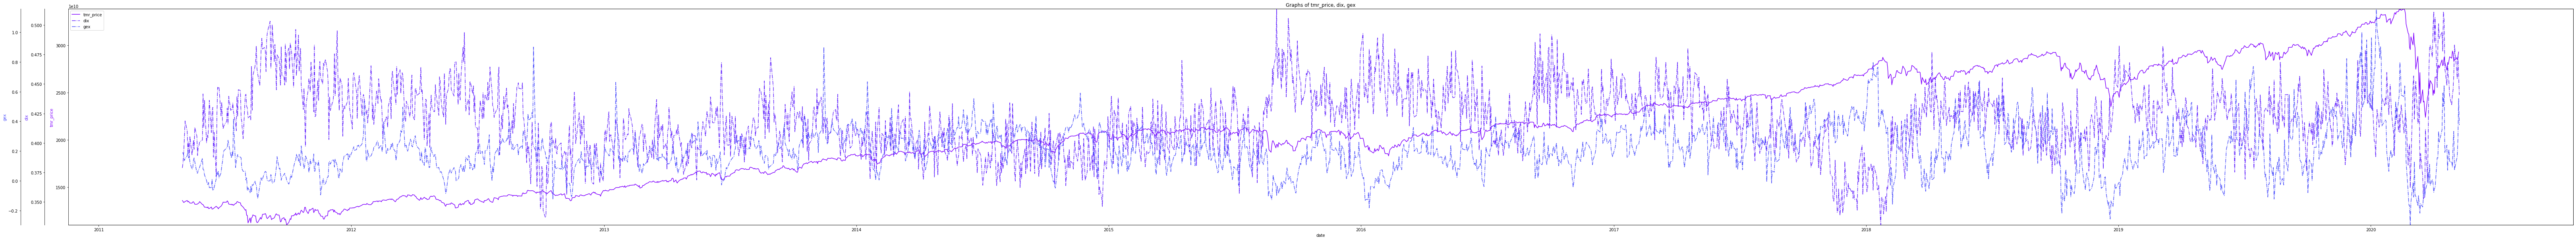

In [7]:
cols = ['tmr_price', 'dix', 'gex']
plot_cols_compare(cols)

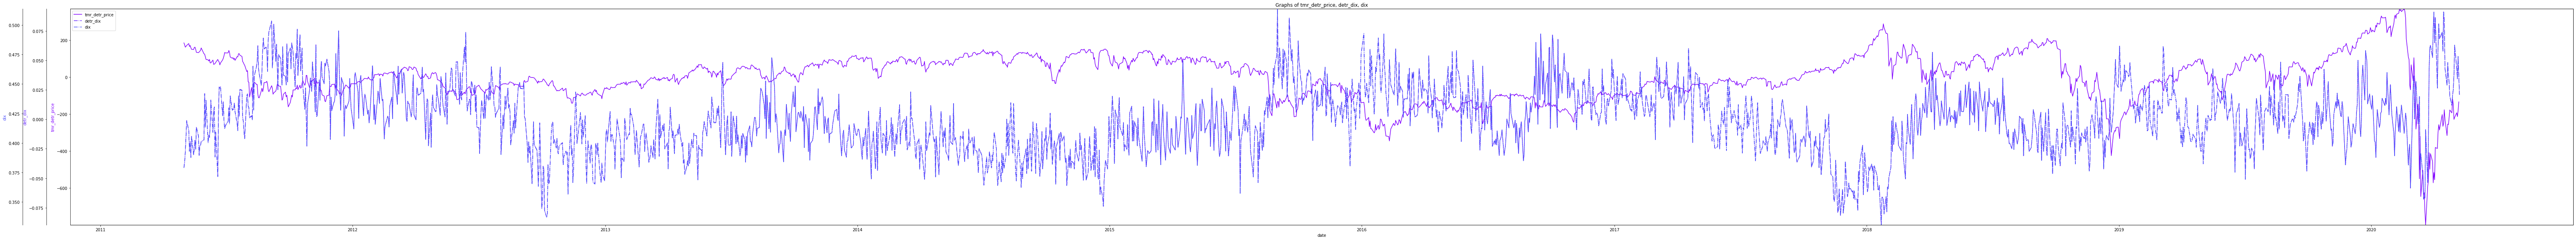

In [8]:
cols = ['tmr_detr_price', 'detr_dix', 'dix']
plot_cols_compare(cols)

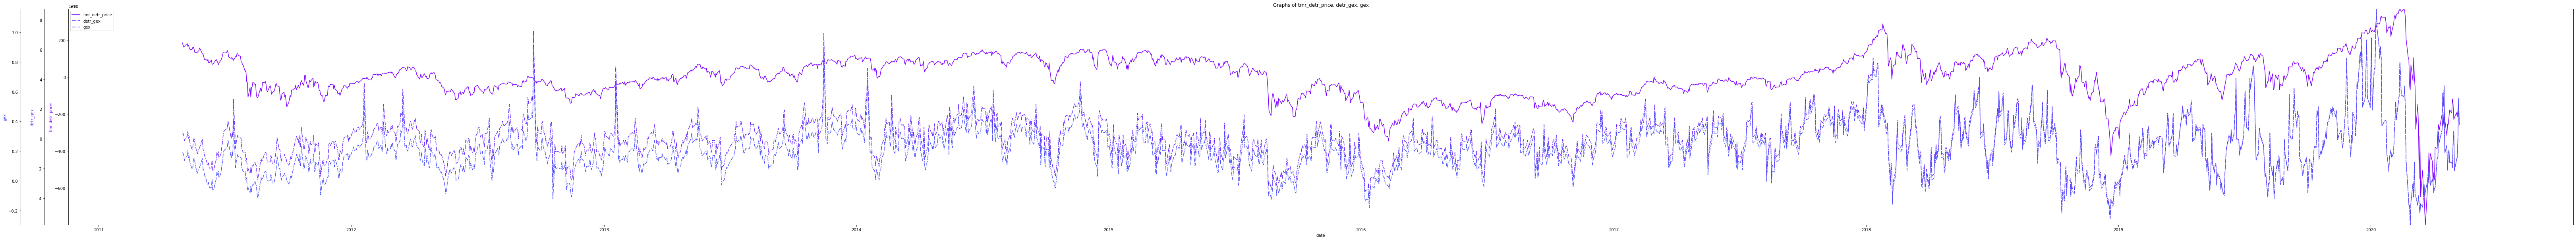

In [9]:
cols = ['tmr_detr_price', 'detr_gex', 'gex']
plot_cols_compare(cols)

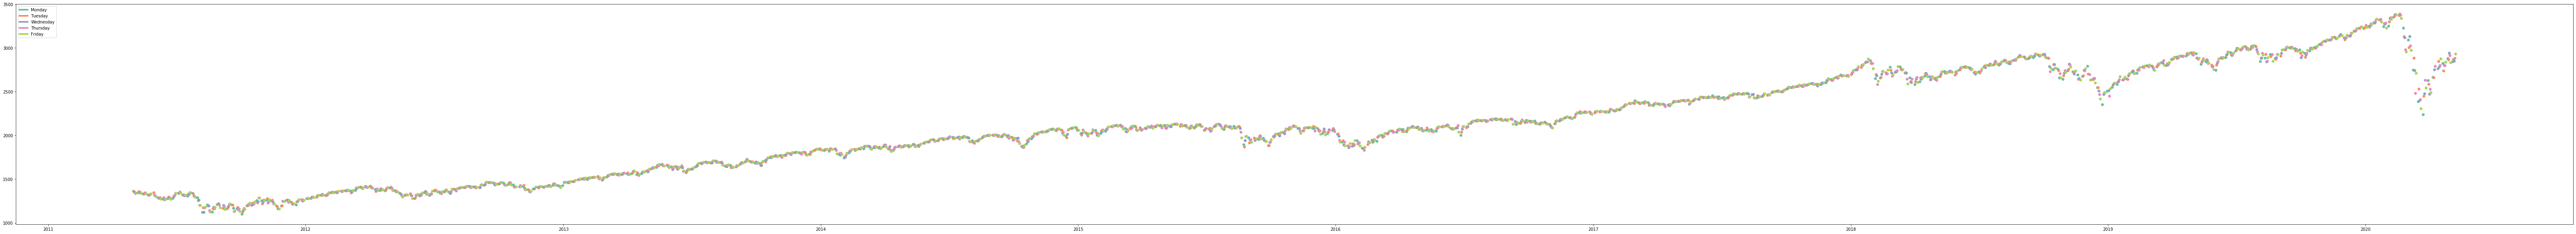

In [10]:
plot_dayofweek_target('price')

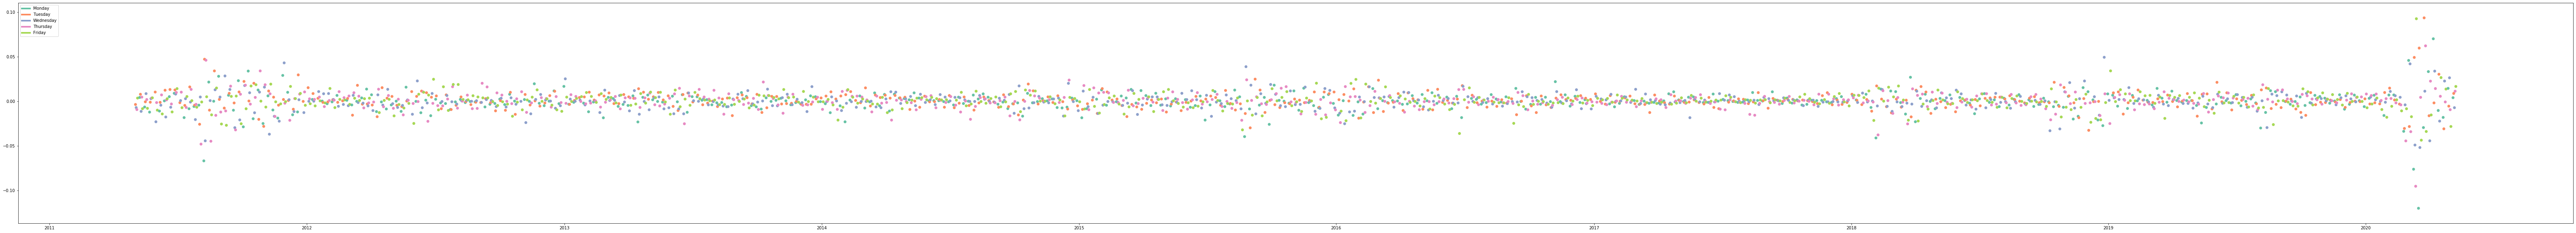

In [11]:
plot_dayofweek_target('simple_ret')

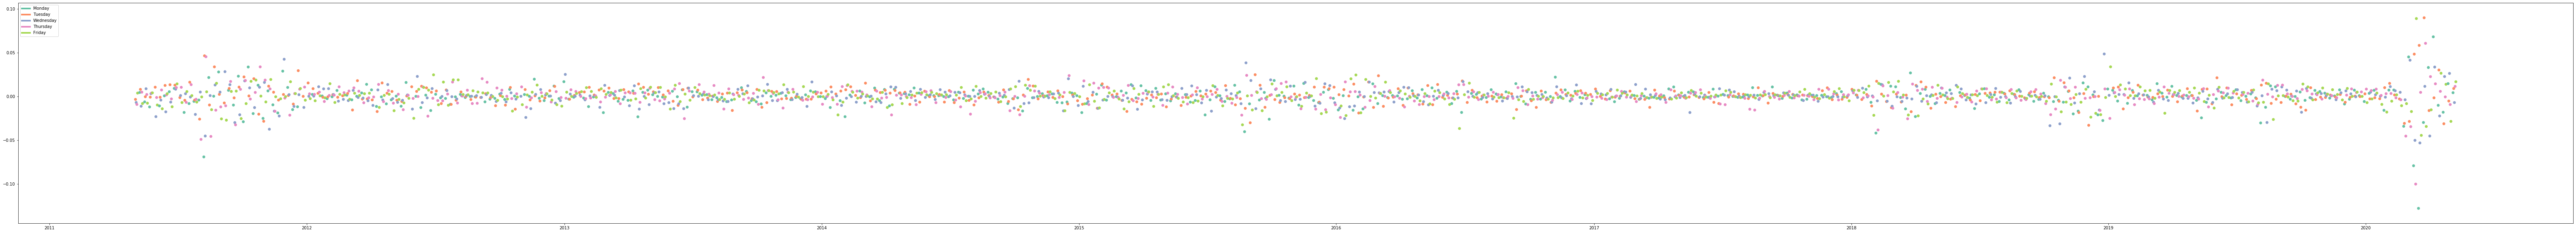

In [12]:
plot_dayofweek_target('log_ret')

In [13]:
dix.head()

price       dix           gex  dix_1d_pct_chg  \
date                                                              
2011-05-02  1361.219971  0.378842  1.897313e+09             NaN   
2011-05-03  1356.619995  0.383411  1.859731e+09        1.206038   
2011-05-04  1347.319946  0.392122  1.717764e+09        2.271901   
2011-05-05  1335.099976  0.405457  1.361864e+09        3.400785   
2011-05-06  1340.199951  0.418649  1.490329e+09        3.253525   

            gex_1d_pct_chg  gamma_sign  gamma_flipped  dix_gte_.4  sma_20  \
date                                                                        
2011-05-02             NaN         1.0              1           0     NaN   
2011-05-03       -1.980797         1.0              0           0     NaN   
2011-05-04       -7.633730         1.0              0           0     NaN   
2011-05-05      -20.718771         1.0              0           1     NaN   
2011-05-06        9.432977         1.0              0           1     NaN   

                 ema_20  simple_ret   log_ret  detr_price  detr_dix  \
date                                                                  
2011-05-02  1361.219971         NaN       NaN  190.578284 -0.040830   
2011-05-03  1358.804984   -0.003379 -0.003385  185.144082 -0.036261   
2011-05-04  1354.587747   -0.006855 -0.006879  175.009807 -0.027551   
2011-05-05  1348.961929   -0.009070 -0.009111  161.955611 -0.014216   
2011-05-06  1346.842481    0.003820  0.003813  166.221360 -0.001025   

                detr_gex    tmr_price  tmr_detr_price  tmr_simple_ret  \
date                                                                    
2011-05-02  3.962420e+08  1356.619995      185.144082       -0.003379   
2011-05-03  3.580575e+08  1347.319946      175.009807       -0.006855   
2011-05-04  2.154881e+08  1335.099976      161.955611       -0.009070   
2011-05-05 -1.410140e+08  1340.199951      166.221360        0.003820   
2011-05-06 -1.315222e+07  1346.290039      171.477223        0.004544   

            tmr_log_ret  tmr_r_or_g  
date                                 
2011-05-02    -0.003385        -1.0  
2011-05-03    -0.006879        -1.0  
2011-05-04    -0.009111        -1.0  
2011-05-05     0.003813         1.0  
2011-05-06     0.004534         1.0

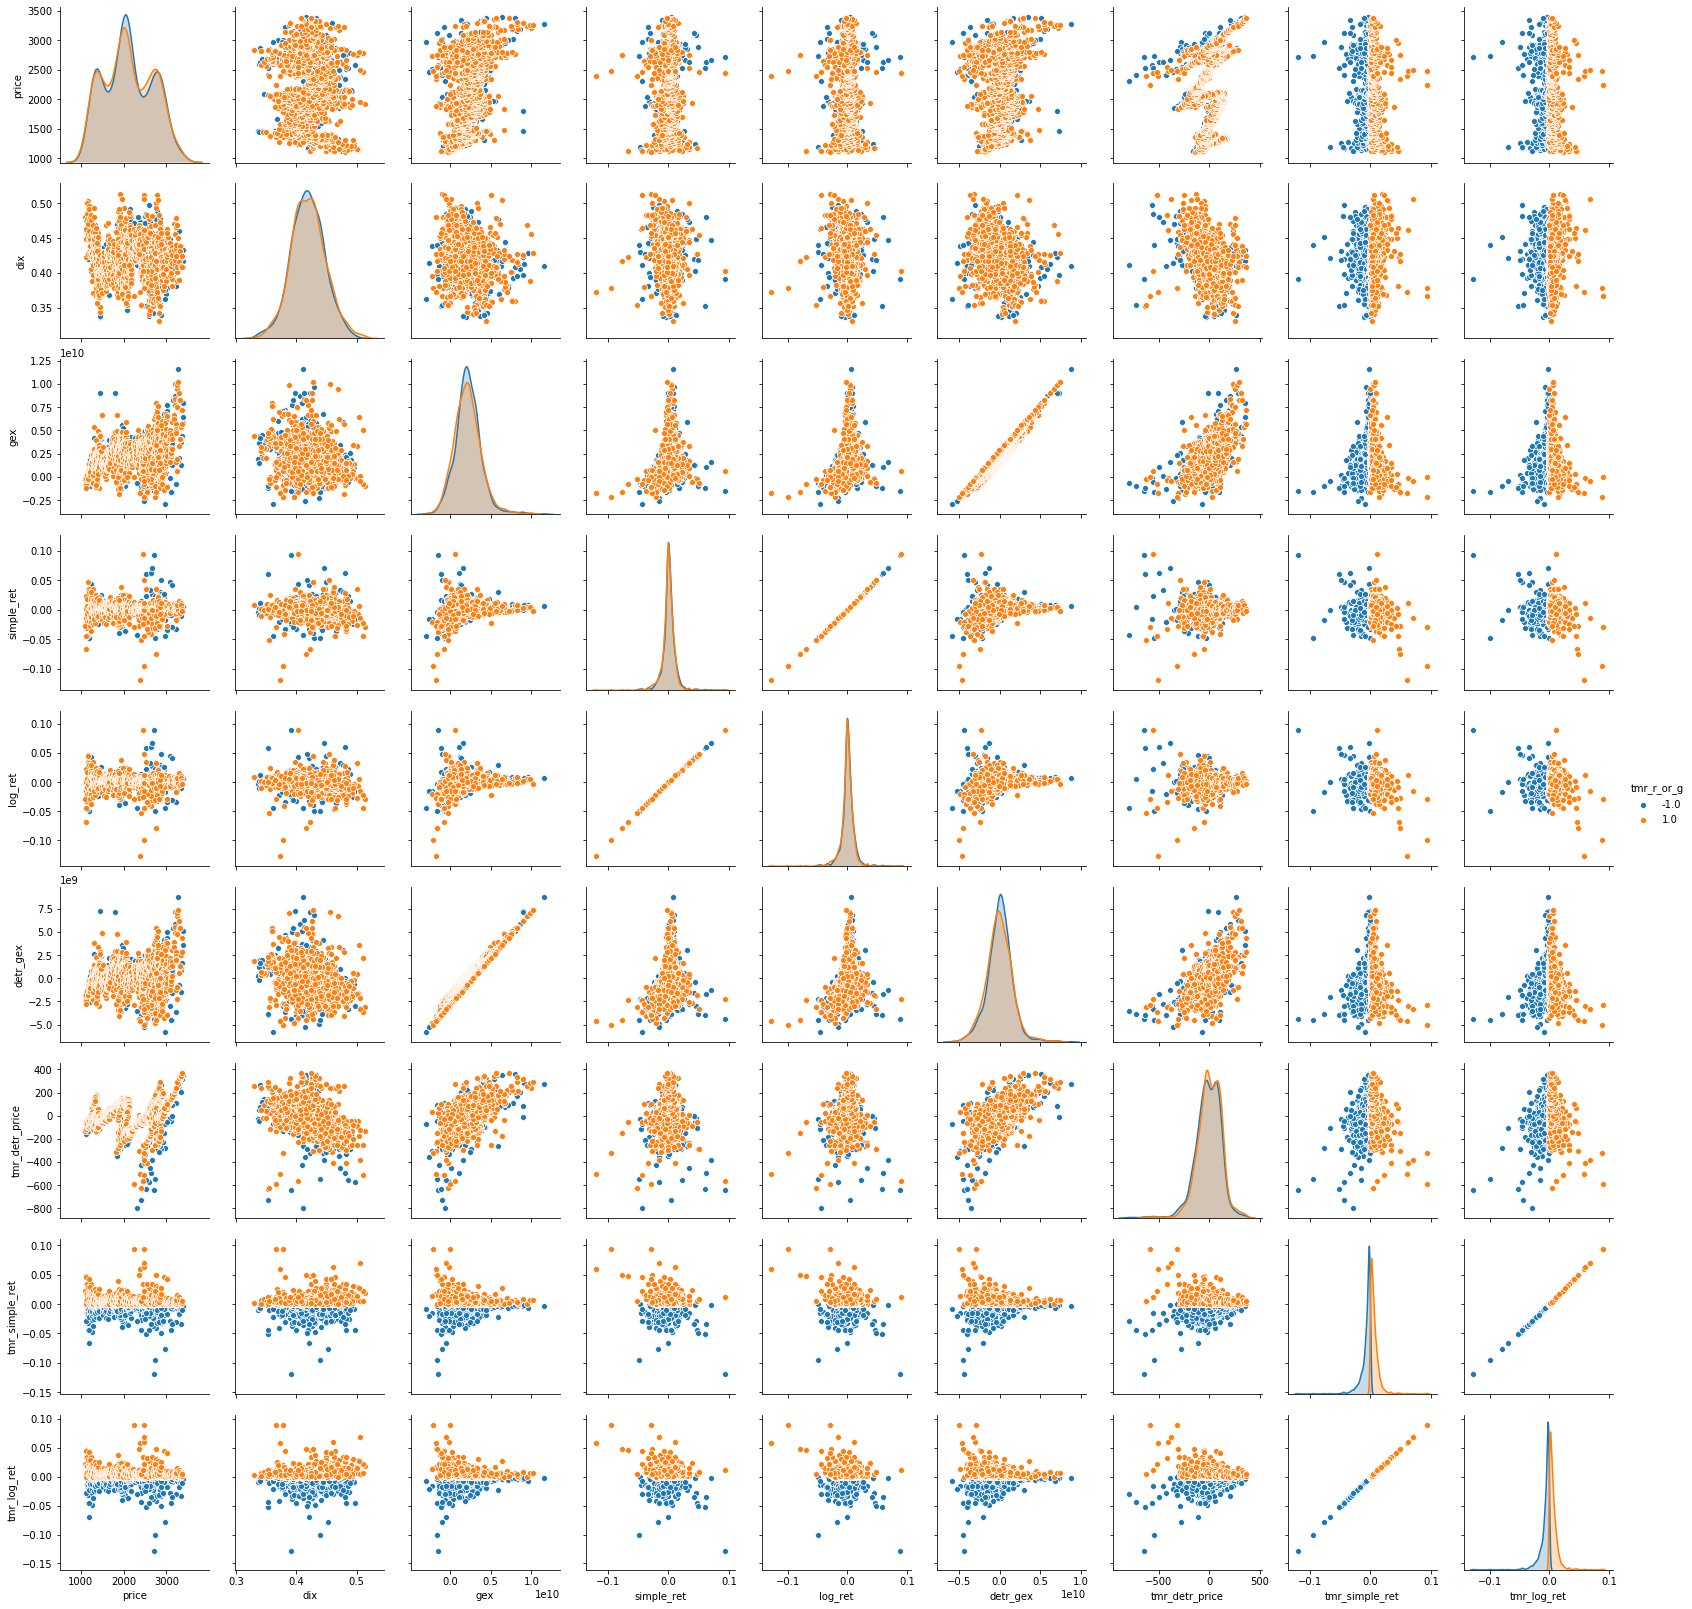

In [14]:
sns_df = dix[['price', 'dix', 'gex', 'tmr_r_or_g', 'detr_gex', 'tmr_detr_price', 'tmr_simple_ret', 'tmr_log_ret', 'simple_ret', 'log_ret']].copy().dropna()
sns_df['tmr_r_or_g'] = sns_df['tmr_r_or_g'].astype(str)
sns.pairplot(sns_df, hue='tmr_r_or_g', vars = ['price', 'dix', 'gex', 'simple_ret', 'log_ret', 'detr_gex', 'tmr_detr_price', 'tmr_simple_ret', 'tmr_log_ret'])

(2269, 20)
(2248, 20)


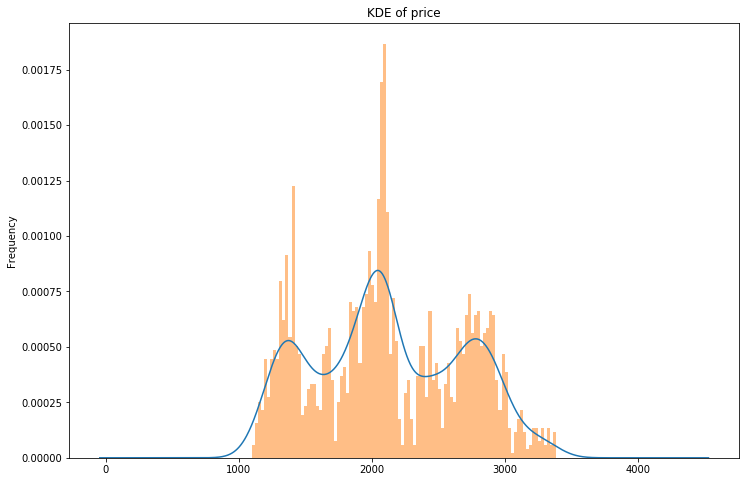

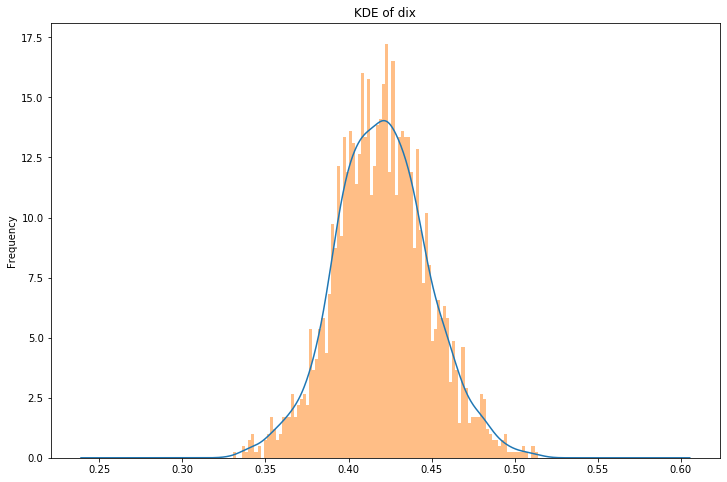

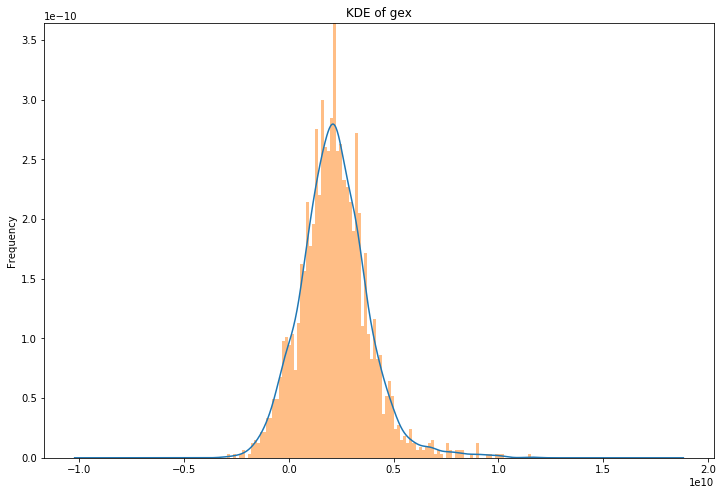

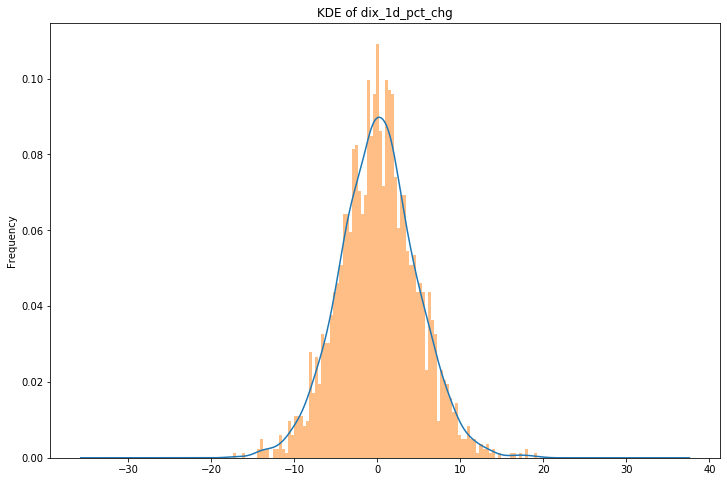

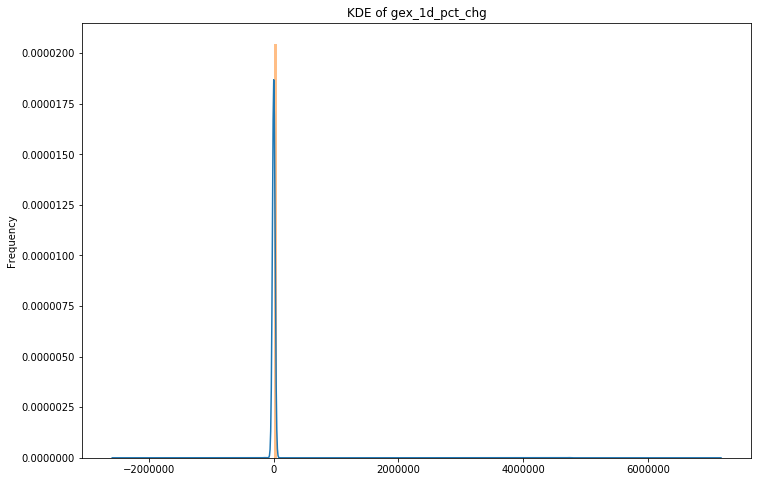

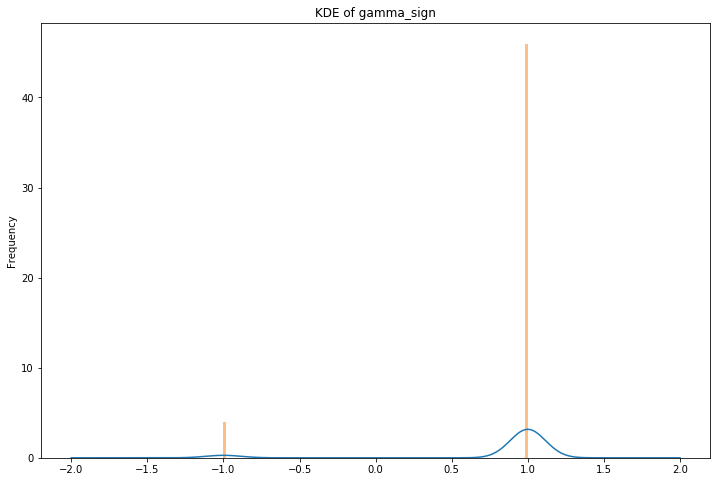

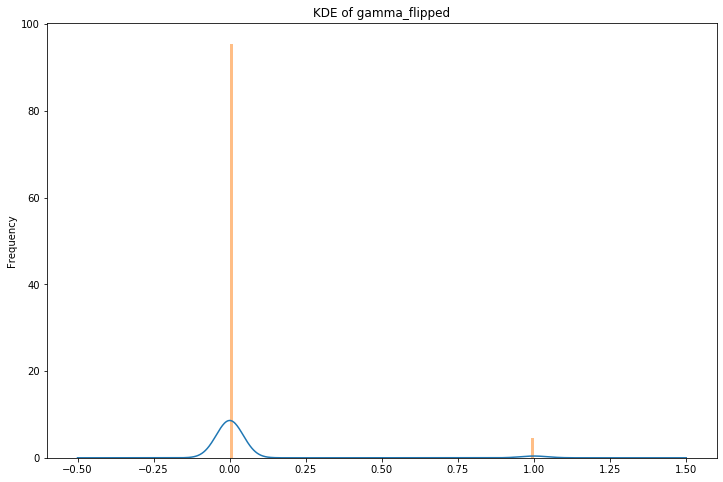

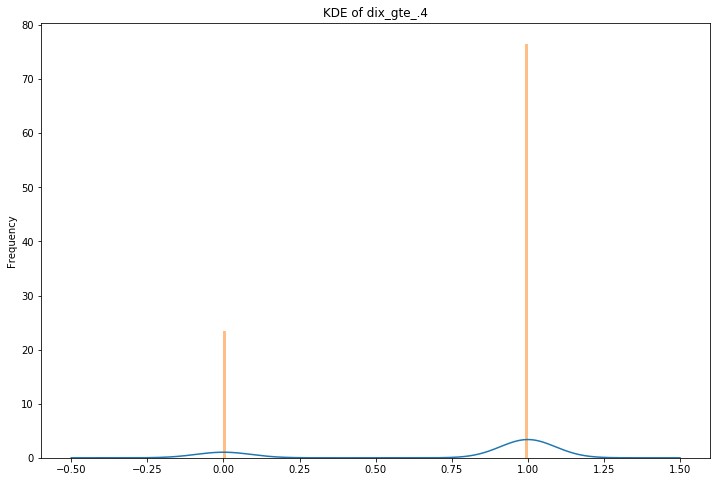

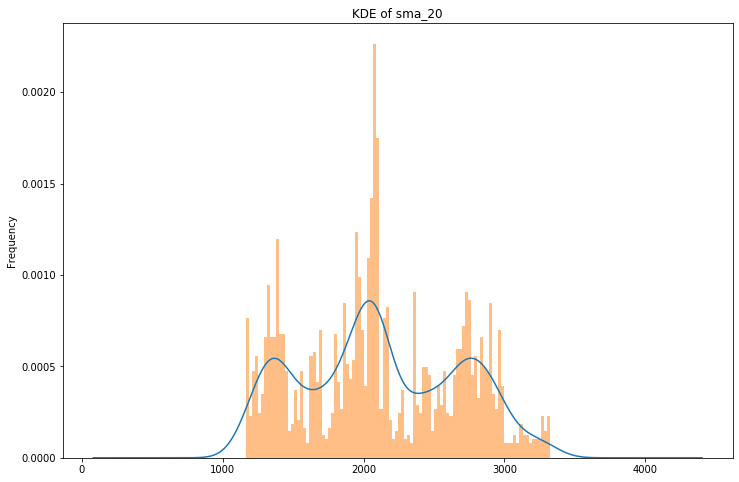

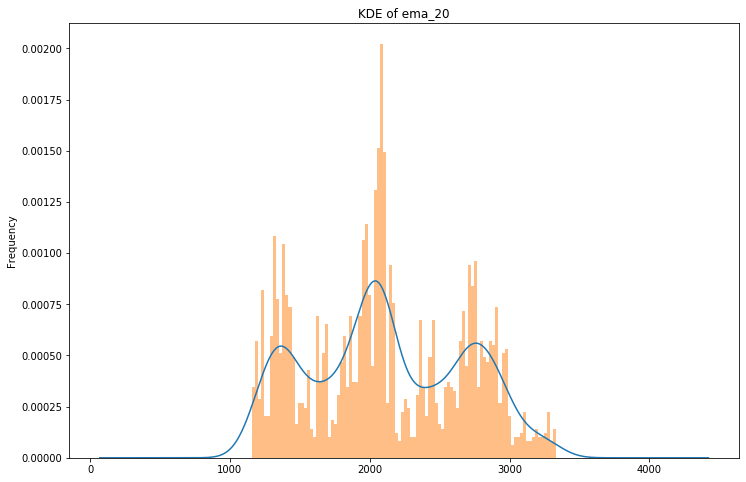

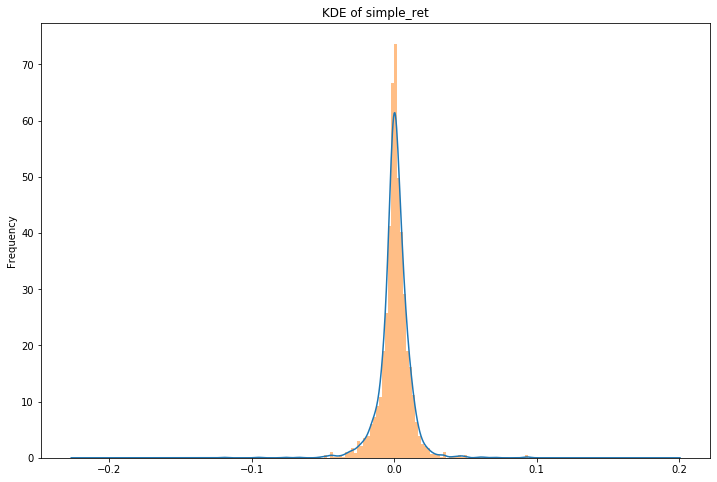

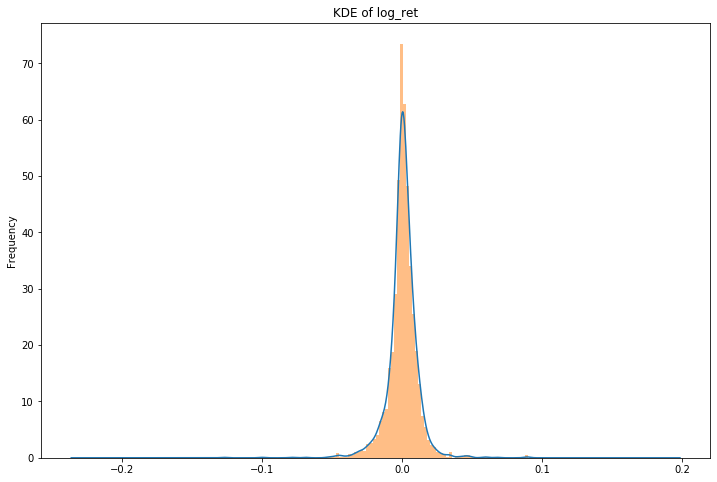

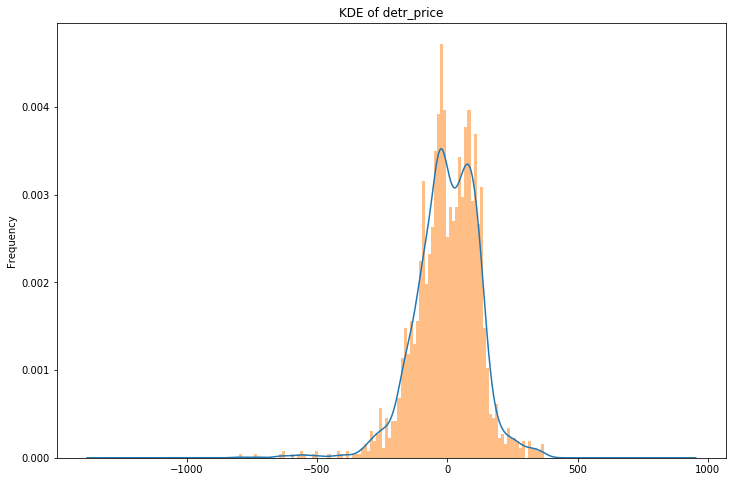

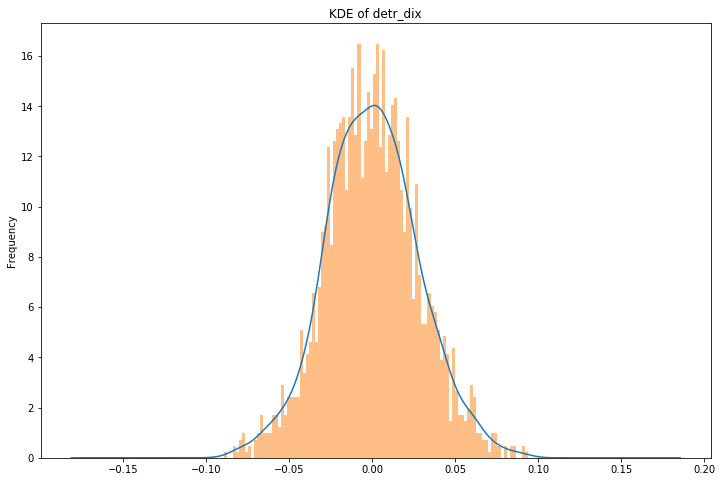

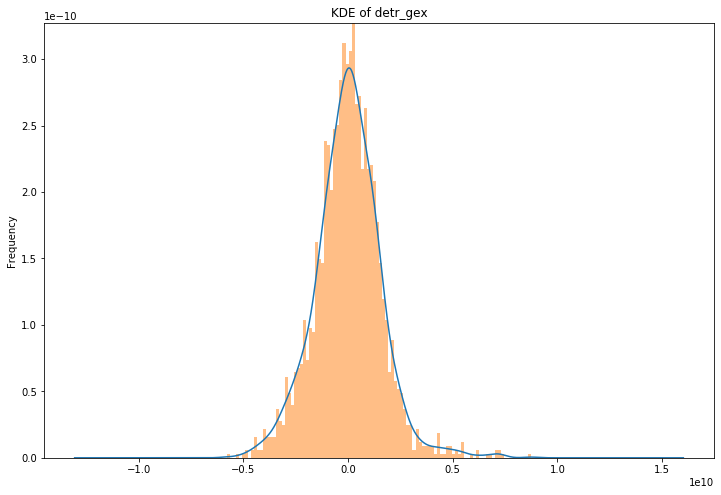

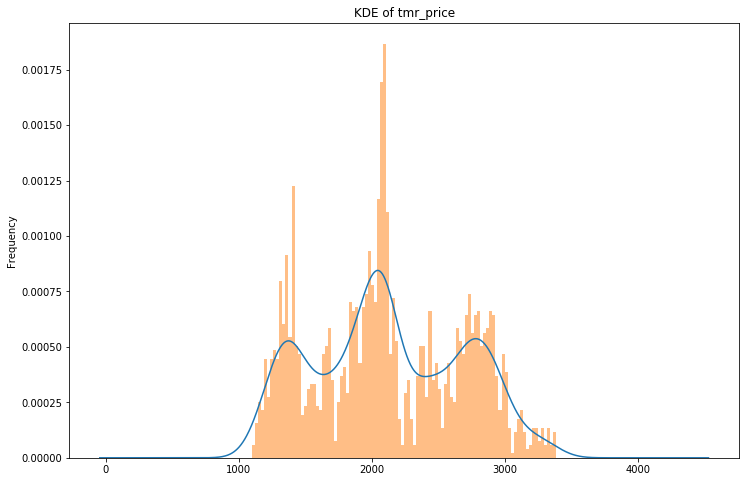

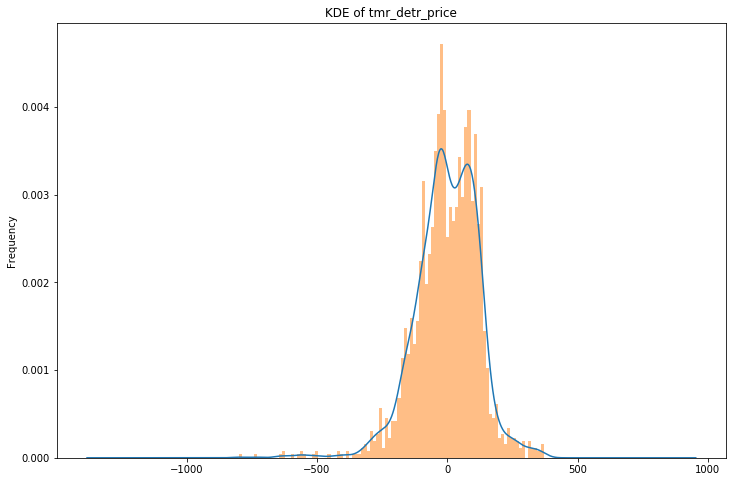

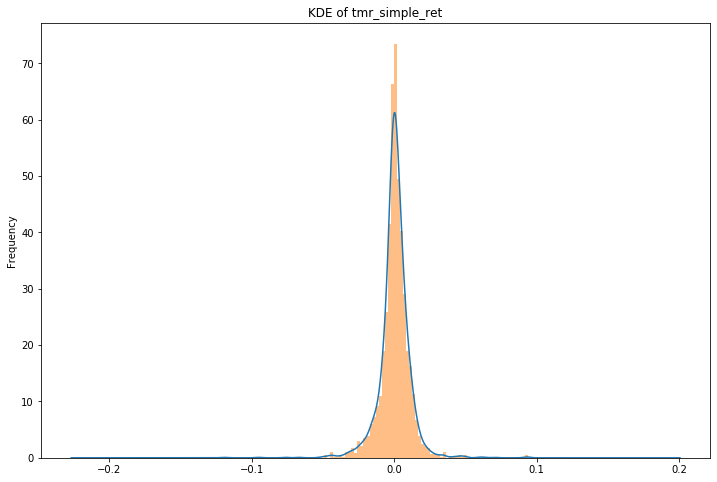

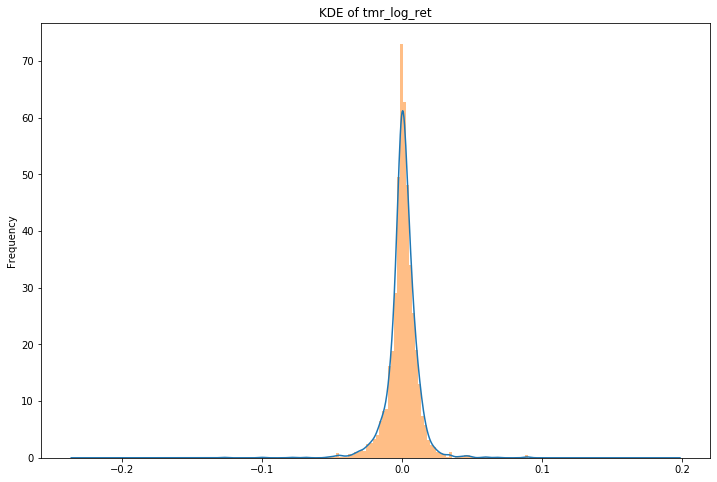

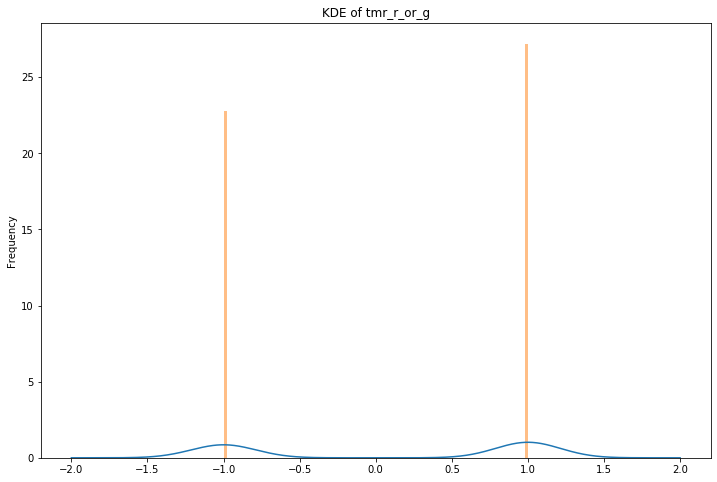

In [15]:
# dropnas
with pd.option_context('mode.use_inf_as_na', True):
    print(dix.shape)
    dix = dix.dropna(how='any')
    print(dix.shape)

for col in dix.columns:
    fig = plt.figure(figsize=(12,8))
    dix[col].plot.kde()
    dix[col].plot.hist(bins=100, alpha = .5, density=True)
    plt.title(f"KDE of {col}")
    plt.show()

## fbprophet

In [16]:
# decomposable time series model of
# trend, seasonality (periodic changes), holidays, errors

# generalized additive model, not a generative model like ARIMA

# Pros to GAM:
# 1) Flexible - accomodate seasnality and multiple periods
# 2) Does not require even-spacing, no need to interpolate
# 3) Fast to fit - framed as a curve fitting problem
# 4) More easily interpretable parameters - extension of regression

$
y(t) = g(t) + s(t) + h(t) + \epsilon_t
$

In [17]:
fb_df = ori_dix.copy()
with pd.option_context('mode.use_inf_as_na', True):
    fb_df = fb_df.dropna()
#     fb_df.dropna(inplace=True)
# get rid of the one datapoint where it closed at same price
fb_df = fb_df.query('tmr_r_or_g != 0')
fb_df.reset_index(inplace=True)
fb_df.rename({'date': 'ds'}, axis=1, inplace=True)
fb_df_base = fb_df.copy()

# Check for stationarity in y, whatever I choose it to be.
# Ljung-box test and dickey-fuller test
# qq plot and jarque-bera test for looking at heavy tails
# other series to try
# log price https://orfe.princeton.edu/~jqfan/fan/FinEcon/chap1.pdf pg 23
# log return
# detrended price?
# deterended dix/gex?

In [18]:
def setup_fbprophet(df, split_date, target_col, exclude_cols = None, prophet_args = None):
    '''
    sets the y variable, splits train and test, and builds
    the fbprophet model adding all other variables as
    additional regressors
    exclude_cols is a list of column names to not include in the model
    
    returns df_train, df_test, m (fbprophet model)
    '''
    fb_df = df.copy()
    
    # set y
    if target_col in fb_df.columns:
        if 'tmr' in target_col:
            print('Found column with "tmr" existing. Setting to y.')
            fb_df['y'] = fb_df[target_col]
            fb_df.drop(target_col, axis=1, inplace=True)
        else:
            print(f"Making target as tomorrow's {target_col}")
            fb_df['y'] = fb_df[target_col].shift(-1)
    else:
        # todo
        print('Do this code')
        raise ValueError
    
    # make train and test sets
    print(f'Splitting test and train at {split_date}')
    df_test = fb_df.query('ds >= @split_date')
    df_train = fb_df.query('ds < @split_date')
    
    # prophet stuff
    if prophet_args:
        m = Prophet(**prophet_args)
    else:
        m = Prophet() # daily_seasonality=True
        
    # setup model, add all other columns as regressors
    nec_cols = ['ds', 'y']
    if exclude_cols:
        nec_cols.extend(exclude_cols)
    for col in fb_df.columns:
        if col not in nec_cols:
            print(f"Adding {col} as a regressor")
            m.add_regressor(col)

    return df_train, df_test, m

### try and predict price

Shows Heteroscedasticity in stock prices


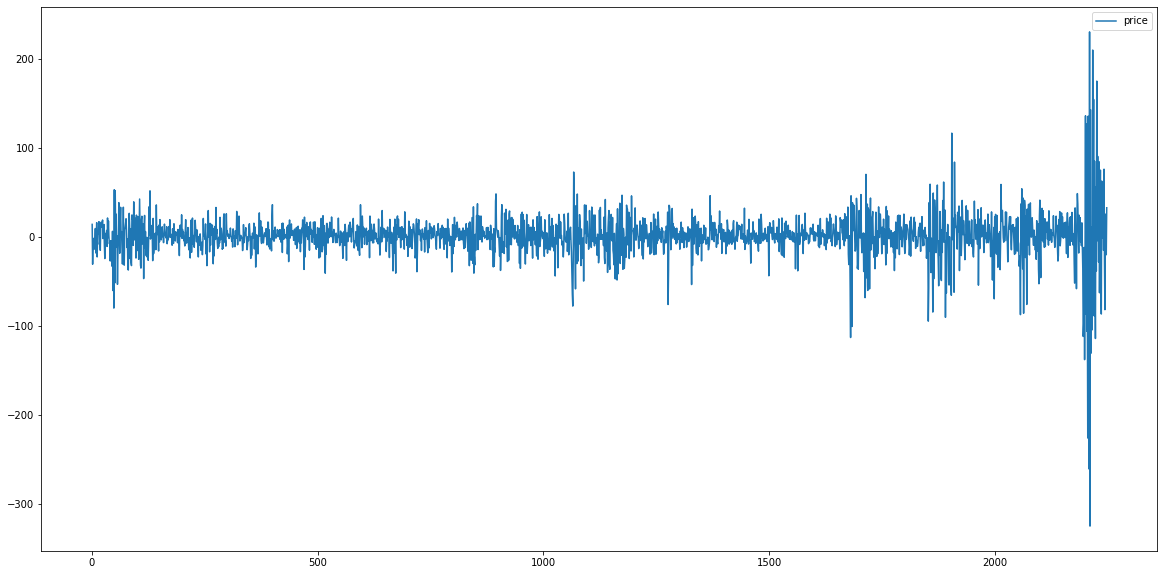

In [19]:
# July 1st 2019 and beyond as test set
split_date = "2019-07-01"

# plotting 1 stock-trading day differences, with ~3 dropped rows 
fb_df[['price']].diff().plot(figsize=(20,10))
print('Shows Heteroscedasticity in stock prices')

In [32]:
df_train, df_test, m = setup_fbprophet(fb_df_base, split_date, 'tmr_price',
                                       exclude_cols=['tmr_price', 'tmr_detr_price', 'tmr_simple_ret', 'tmr_log_ret', 'tmr_r_or_g'],
                                       prophet_args= 
                                       {'changepoint_range':.95,                                                                     'changepoint_prior_scale':10, 
                                        'seasonality_mode':'multiplicative', 
                                        'interval_width': .99})
m.fit(df_train)

forecast = m.predict(df_test)
forecast_cols = ['ds', 'yhat', 'yhat_lower', 'yhat_upper']
forecast[forecast_cols].tail()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Found column with "tmr" existing. Setting to y.
Splitting test and train at 2019-07-01
Adding price as a regressor
Adding dix as a regressor
Adding gex as a regressor
Adding dix_1d_pct_chg as a regressor
Adding gex_1d_pct_chg as a regressor
Adding gamma_sign as a regressor
Adding gamma_flipped as a regressor
Adding dix_gte_.4 as a regressor
Adding sma_20 as a regressor
Adding ema_20 as a regressor
Adding simple_ret as a regressor
Adding log_ret as a regressor
Adding detr_price as a regressor
Adding detr_dix as a regressor
Adding detr_gex as a regressor


ds         yhat   yhat_lower   yhat_upper
211 2020-05-01  2882.343469  2772.999995  2980.148967
212 2020-05-04  2894.445693  2787.980732  2996.772919
213 2020-05-05  2917.599312  2802.158054  3021.931147
214 2020-05-06  2902.118841  2795.486855  2999.360950
215 2020-05-07  2934.996117  2836.029612  3032.805491

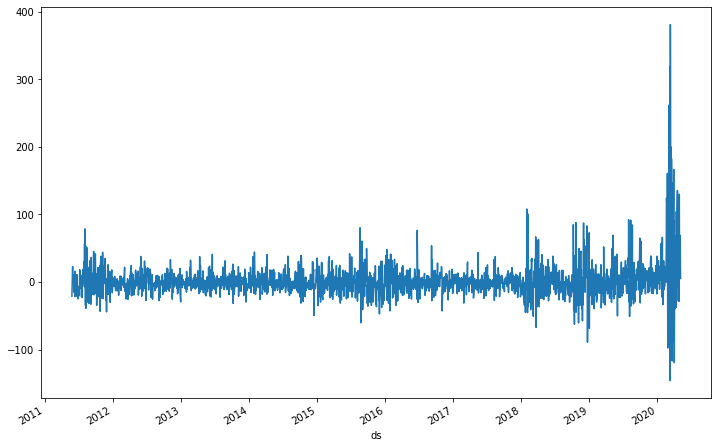

In [33]:
# look at the residuals
cols_of_int = ['yhat', 'yhat_lower', 'yhat_upper']
for col in cols_of_int:
    df_test[col] = None
    df_train[col] = None
    
df_test[cols_of_int] = forecast[cols_of_int].values
df_test['residuals'] = df_test['yhat'] - df_test['y']

train_forecast = m.predict()
df_train[cols_of_int] = train_forecast[cols_of_int].values
df_train['residuals'] = df_train['yhat'] - df_train['y']

resid_df = pd.concat([df_train, df_test])
resid_df.set_index('ds', inplace=True)

# with test starting at july 2019, we see there are problems with residuals
resid_df.residuals.plot(figsize=(12,8))

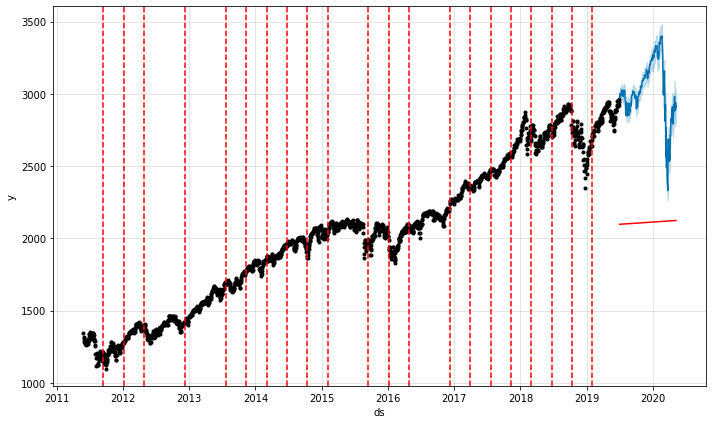

In [34]:
# Python
fig1 = m.plot(forecast)
a = add_changepoints_to_plot(fig1.gca(), m, forecast)

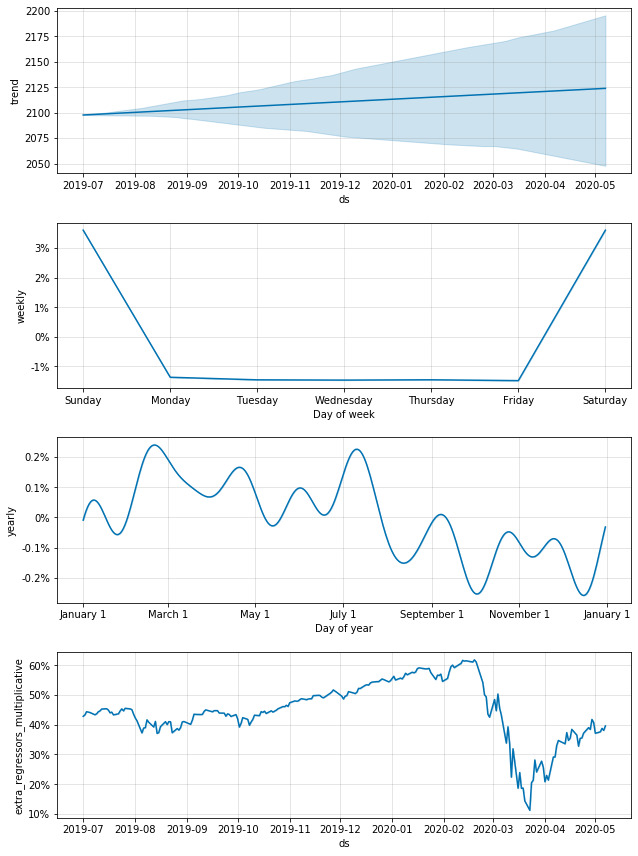

In [35]:
# Python
fig2 = m.plot_components(forecast)

# Cross Validation

In [44]:
365 * 7

2555

In [45]:
df_cv = cross_validation(m, initial='2555 days', period='180 days', horizon = '100 days')
df_cv.head()

INFO:fbprophet:Making 2 forecasts with cutoffs between 2018-09-21 00:00:00 and 2019-03-20 00:00:00


ds         yhat   yhat_lower   yhat_upper        y     cutoff
0 2018-09-24  2917.468066  2882.247870  2955.760024  2915.58 2018-09-21
1 2018-09-25  2915.507709  2877.242748  2952.706841  2906.02 2018-09-21
2 2018-09-26  2907.004440  2866.660802  2945.949468  2914.00 2018-09-21
3 2018-09-27  2915.889517  2878.571892  2951.770213  2913.95 2018-09-21
4 2018-09-28  2913.991841  2878.617915  2951.963592  2924.64 2018-09-21

In [46]:
df_cv.tail()

ds         yhat   yhat_lower   yhat_upper        y     cutoff
132 2019-06-24  2928.385292  2880.634880  2981.299898  2917.38 2019-03-20
133 2019-06-25  2900.381505  2851.983195  2960.444319  2913.78 2019-03-20
134 2019-06-26  2898.890078  2849.571552  2953.791258  2924.92 2019-03-20
135 2019-06-27  2909.662485  2861.227375  2967.160816  2941.76 2019-03-20
136 2019-06-28  2925.350468  2871.183329  2977.389903  2964.33 2019-03-20

In [47]:
df_p = performance_metrics(df_cv)

In [48]:
df_p

horizon          mse       rmse        mae      mape     mdape  coverage
0   10 days   407.569921  20.188361  14.283920  0.005029  0.003641  0.923077
1   11 days   211.482233  14.542429  10.613521  0.003715  0.003265  1.000000
2   12 days   253.811340  15.931458  12.450270  0.004348  0.003641  1.000000
3   13 days   256.788977  16.024637  12.686344  0.004427  0.003641  1.000000
4   14 days   245.611723  15.672004  12.246142  0.004266  0.003641  1.000000
5   15 days   264.364688  16.259295  13.105243  0.004559  0.003925  1.000000
6   16 days   262.985224  16.216819  13.042570  0.004534  0.003641  1.000000
7   17 days   260.320966  16.134465  12.915542  0.004489  0.003616  1.000000
8   18 days  1008.129544  31.751056  19.023033  0.006691  0.003616  0.923077
9   19 days  1246.739596  35.309200  22.155927  0.007872  0.003925  0.846154
10  20 days  1279.662229  35.772367  23.740054  0.008448  0.005401  0.846154
11  21 days  1320.298652  36.335914  24.536830  0.008765  0.005401  0.846154
12  22 days  1350.264350  36.745943  25.364948  0.009047  0.005401  0.846154
13  23 days  1347.464638  36.707828  25.257504  0.009008  0.005401  0.846154
14  24 days  1458.009088  38.183885  27.706445  0.009884  0.005972  0.769231
15  25 days  1460.016113  38.210157  27.763314  0.009918  0.006413  0.769231
16  26 days  1782.197843  42.216085  31.745017  0.011371  0.007849  0.692308
17  27 days   860.655237  29.336926  22.699336  0.008113  0.007540  0.807692
18  28 days   782.833947  27.979170  21.852589  0.007804  0.006413  0.846154
19  29 days   764.165312  27.643540  21.241538  0.007578  0.006413  0.846154
20  31 days   918.686523  30.309842  23.655144  0.008464  0.006413  0.769231
21  32 days  1989.981985  44.609214  31.458796  0.011425  0.007540  0.692308
22  33 days  2028.623155  45.040239  32.438737  0.011776  0.007540  0.692308
23  34 days  2381.485724  48.800468  34.391134  0.012593  0.007540  0.692308
24  35 days  2330.972820  48.280149  34.058274  0.012552  0.007540  0.692308
25  36 days  2349.079824  48.467307  34.816001  0.012793  0.007540  0.692308
26  37 days  2346.542279  48.441122  34.984132  0.012832  0.007259  0.692308
27  38 days  2286.688684  47.819334  33.436548  0.012279  0.007259  0.692308
28  39 days  2233.536850  47.260309  32.384881  0.011908  0.004647  0.692308
29  40 days  2055.594426  45.338664  29.594925  0.010886  0.004647  0.769231
30  41 days  1183.400717  34.400592  24.210250  0.008831  0.004647  0.769231
31  42 days   950.286743  30.826721  21.691688  0.007903  0.004139  0.807692
32  43 days   814.301512  28.535969  21.450095  0.007708  0.004647  0.846154
33  44 days   671.132501  25.906225  19.020428  0.006791  0.004139  0.884615
34  45 days   564.003371  23.748755  18.101092  0.006426  0.004647  0.923077
35  46 days   557.116494  23.603315  17.930907  0.006391  0.004647  0.923077
36  47 days   797.826650  28.245825  22.881384  0.008137  0.006798  0.923077
37  48 days  1076.617602  32.811852  26.132645  0.009302  0.007893  0.846154
38  49 days  1565.576665  39.567369  29.505569  0.010562  0.007893  0.807692
39  50 days  1451.586935  38.099697  28.174196  0.010056  0.007893  0.846154
40  51 days  1715.348322  41.416764  31.780818  0.011330  0.007893  0.769231
41  52 days  1806.276352  42.500310  33.674521  0.012030  0.012884  0.769231
42  53 days  1937.397925  44.015883  35.069001  0.012636  0.014145  0.692308
43  54 days  1981.352451  44.512385  36.343023  0.013080  0.014145  0.692308
44  55 days  1965.295741  44.331656  36.359829  0.013114  0.011947  0.692308
45  56 days  2371.373320  48.696749  40.091095  0.014534  0.011947  0.653846
46  57 days  2233.131157  47.256017  38.522762  0.013962  0.011615  0.692308
47  58 days  1925.577073  43.881398  35.980837  0.013016  0.011615  0.730769
48  59 days  2242.647266  47.356597  39.457311  0.014373  0.011615  0.692308
49  60 days  2361.020397  48.590332  41.381412  0.015142  0.011947  0.692308
50  61 days  2374.602342  48.729892  41.092044  0.015117  0.011615  0.692308


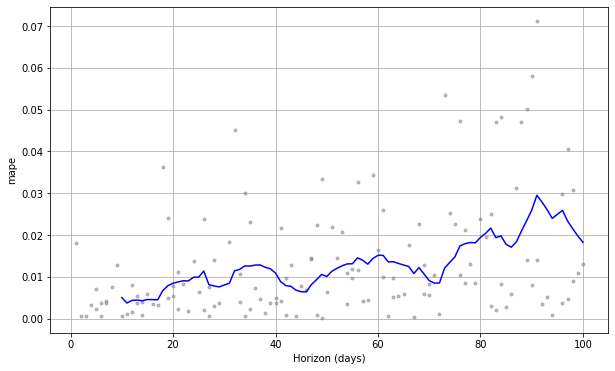

In [49]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

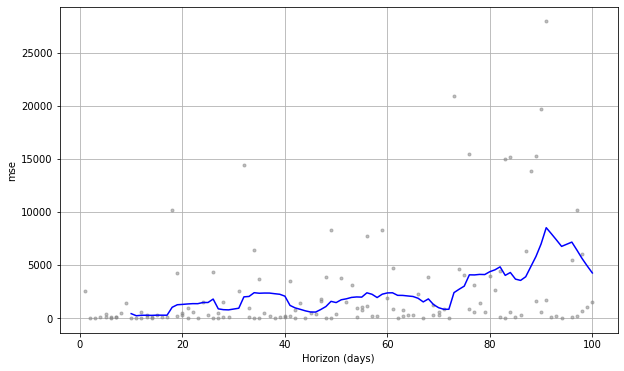

In [50]:
fig = plot_cross_validation_metric(df_cv, metric='mse')

# Dennis

In [ ]:
import quandl
import pandas as pd
import stocker
quandl.ApiConfig.api_key = '1MN4xbFX3wwQNXvao-9-'
# quandl.ApiConfig.api_version = '2015-04-09'

# Matplotlib for plotting
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates
import seaborn as sns
%matplotlib inline



plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams.update({'font.size': 14})
plt.style.use('fivethirtyeight')
matplotlib.rcParams['axes.labelsize'] = 18
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['text.color'] = 'k'
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from pandas_datareader import data
import datetime as dt


import warnings
import itertools
import numpy as np
import statsmodels.api as sm

from pytrends.request import TrendReq

In [ ]:
# start is calculated as 365 days X years
years = 12
end = dt.datetime.today().strftime('%Y-%m-%d')  # today as the end date
start = (dt.datetime.today() - dt.timedelta(days=365*years)).strftime('%Y-%m-%d')  
GILD = data.DataReader('GILD', 'yahoo', start, end)
SGEN = data.DataReader('SGEN', 'yahoo', )

In [51]:
# nested column set in df
df = data.DataReader(('GILD', 'SGEN'), 'yahoo', start, end)

NameError: name 'data' is not defined

In [ ]:
# The adjusted close accounts for stock splits, so that is what we should graph
plt.plot(GILD.index, GILD['Adj Close'])
plt.title('Gilead Stock Price')
plt.ylabel('Price ($)')
plt.show()

In [ ]:
plt.plot(SGEN.index, SGEN['Adj Close'])
plt.title('Seattle Genetics Stock Price')
plt.ylabel('Price ($)')
plt.show()

In [52]:
GILD.tail()
SGEN.tail()

NameError: name 'GILD' is not defined

In [ ]:
import plotly
import fbprophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
import plotly.graph_objects as go
print(fbprophet.__version__)

In [ ]:
GILD.reset_index(inplace = True)
# Prophet requires columns ds (Date) and y (value)
gild = GILD.rename(columns={'Date': 'ds', 'Adj Close': 'y'})
gild

In [ ]:
# Try 3 different changepoints
for changepoint in [.0015, .15, 15]:
        model = fbprophet.Prophet(daily_seasonality=False, changepoint_prior_scale=changepoint)
        model.fit(gild)
        
        future = model.make_future_dataframe(periods=365, freq = 'D')
        future = model.predict(future)
        
        gild[changepoint] = future['yhat']

In [ ]:

# Actual observations
plt.plot(gild['ds'], gild['y'], 'ko', label = 'Observations')
colors = {.0015: 'b', .15: 'r', 15: 'grey'}

# Plot each of the changepoint predictions
for changepoint in [.0015, .15, 15]:
    plt.plot(gild['ds'], gild[changepoint], color = colors[changepoint], label = '%.4f prior scale' % changepoint)
    
plt.legend(prop={'size': 14})
plt.xlabel('Date'); plt.ylabel('Stock Price'); plt.title('Effect of Changepoint Prior Scale');

In [ ]:
gild_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15)
gild_prophet.fit(gild)

In [ ]:
# Make a future dataframe for 1 year
gild_forecast = gild_prophet.make_future_dataframe(periods=365 , freq='D')

# Make predictions 
gild_forecast = gild_prophet.predict(gild_forecast)

In [ ]:
gild_prophet.plot(gild_forecast, xlabel = 'Date', ylabel = 'Stock prices (Adj. Close)')
plt.title('Stock Prices of Gilead (GILD)')

In [ ]:
gild_prophet.changepoints[:10]

In [ ]:
gild_forecast.columns

## Diagnostics

In [ ]:
df_cv = cross_validation(gild_prophet, initial='730 days', period='180 days', horizon = '100 days')
df_cv.head()

In [54]:
df_p = performance_metrics(df_cv)

In [55]:
df_p.mape.min()

0.0037148077915061272

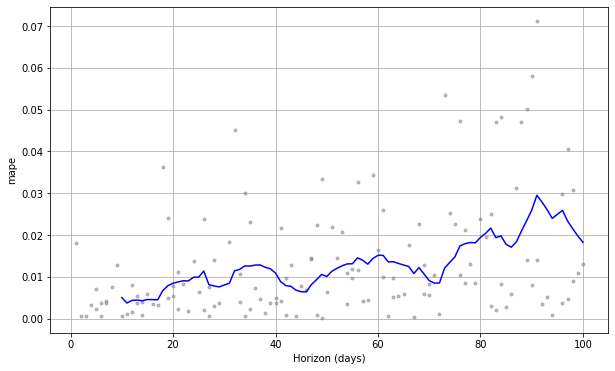

In [56]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [57]:
df_p.mse.min()

211.48223322951515

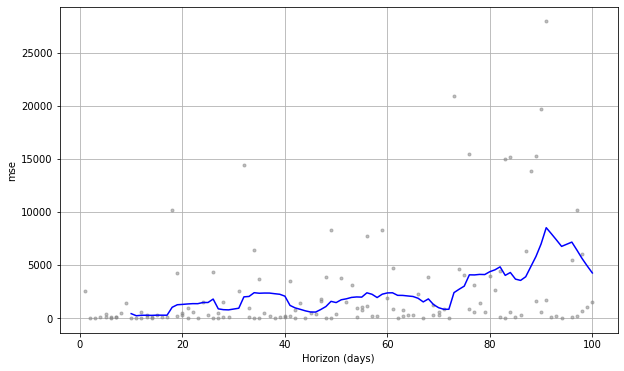

In [58]:
fig = plot_cross_validation_metric(df_cv, metric='mse')

In [59]:
gild_prophet.plot_components(gild_forecast);

NameError: name 'gild_prophet' is not defined

In [60]:
y = gild.set_index('ds')

NameError: name 'gild' is not defined

In [ ]:
y = y[['y']]

In [ ]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

In [ ]:
train_data = y[start: '2020-03-17']
test_data = y['2020-03-18': '2020-05-04']

In [ ]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_data, #y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue

In [ ]:
print('The model SARIMAX{}x{} attains the lowest AIC of {} out of all the models we have considered. '
      .format(SARIMAX_model[AIC.index(min(AIC))][0], 
              SARIMAX_model[AIC.index(min(AIC))][1], 
              min(AIC)
             )
     )


In [ ]:
# Let's fit this model
model_sarima = sm.tsa.statespace.SARIMAX(y,
                                order=SARIMAX_model[AIC.index(min(AIC))][0],
                                seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = model_sarima.fit()


In [ ]:
results.plot_diagnostics (figsize=(15, 12));

## Validating Forecasts

In [ ]:
pred0 = results.get_prediction(start=pd.to_datetime('2020-03-18'), dynamic=False)
pred0_ci = pred0.conf_int()

In [ ]:
ax = y['2020-03-18':].plot(label='observed')
pred0.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred0_ci.index,
                pred0_ci.iloc[:, 0],
                pred0_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Stock Price (Adj Close)')
plt.legend(prop={'size': 14})

plt.show()

In [ ]:
y_forecasted = pred0.predicted_mean
y_truth = y['2020-03-18':]


# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

In [ ]:
mape = np.mean(np.abs(y_forecasted - y_truth)/np.abs(y_truth))

print('The Mean Absolute Percentage Error of our forecasts is {}'.format(round(mape, 2)))

In [ ]:
# changing gear to use dynamic forecasts and conf intervals from the start date onwards. 
pred_dynamic = results.get_prediction(start=pd.to_datetime('2020-03-18'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

In [ ]:
ax = y['2020-03-18':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2020-03-18'), y.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Stock Price(Adj Close)')

plt.legend(prop={'size': 14})
plt.show()

In [ ]:
# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
y_truth = y['2020-03-18':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

In [ ]:
mape = np.mean(np.abs(y_forecasted - y_truth)/np.abs(y_truth))
print('The Mean Absolute Percentage Error of our forecasts is {}'.format(round(mape, 2)))

In [ ]:
# fcast_index = pd.to_datetime(['2020-04-02 9:00am', '2017-04-02 9:00am', ...])

pred2 = results.get_forecast(steps = 365,index = pd.DatetimeIndex(pd.date_range(start='2020-05-05', periods=365)))

# pred2 = results.get_forecast(start=pd.to_datetime('2020-03-18'), end=pd.to_datetime('2020-05-04'),dynamic=False)
pred2_ci = pred2.conf_int()

# print(pred2.predicted_mean.apply(np.exp))

# print (pred2_ci)

## Producing and Visualizing Forecasts

In [ ]:
# days = dt.datetime.strptime(str(pred2_ci.index),  "%m/%d/%Y")
# plt.plot_date(x=days, y=value, fmt="r-")

ax = train_data.plot(label='observed', figsize=(39, 21))
pred0.predicted_mean.plot(ax=ax, label='1-step-ahead Forecast (get_predictions, dynamic=False)')
pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_predictions, dynamic=True)')
pred2.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_forecast)')
ax.fill_between(pred2_ci.index, pred2_ci.iloc[:, 0], pred2_ci.iloc[:, 1], color='k', alpha=.1)
plt.ylabel('Stock Price (Adj. Close)', fontsize=38)
plt.xlabel('Date', fontsize=38)
plt.legend(loc=2, prop={'size': 28})

plt.show()

# Conclusions

In [ ]:
'''
We verified the whitepaper's claim that Gex can dampen or enhance market
volatility depending on its magnitude and sign. The first pass at building
a predictive model with fbprophet shows it has learned a trend and identified
nuances with stock data (no weekends, maybe some seasonality). However, we 
still see heteroscedastic residuals, and larger residuals in the test set
and the recent market turbulence specifically. Next steps can be trying
to finetune fbprophet, add additional time series features, or reframing
the problem into different forms (classification, not time-series, etc.).



Pros that we saw from fbprophet is it's definitely the easier of the two to pick up and implement. 

1. It's tailored made for fast-paced organizations that has forecasting needs like facebook at every level. An example there is it requires you make_future_dataframe as a requirement before you can proceed to the next step.
2. For the out-of-sample, predictions at the end of the FB Prophet section, the confidence apparently spans a narrower area than its correponding counterpart in SARIMA. That gives me a confidence in its predictions

From the SARIMA's perspective, the pros of it is also two folds: 1) It has an algorithm where it will spit out all the possible permutations of the ARIMA(p, d, q)x(s, p, d, q), which allows you to take the trend (which corresponds to the no. of autoregressive terms), differencing, number of lagged forecast errors into account before even fitting a line. I think that's the beauty and rigor it has with respect to time series analysis. That's why ARIMA has been around for so long. 

It has the flexibility to allow you to use the two different functions, namely, get_forecast and get_predictions, within which, there are additional parameters to tune the model for your specific needs. For example, for GILD, the get_prediction with dynamic = False, meaning it uses 1-step ahead forecasting gave a rather accurate prediction both on MSE (Mean Square Error) and MAPE (Mean Absolute Percentage Error).

At the end, I wanted to touch on the fact that from the beginning to end, the only predictor that I used was Stock Price (Adj Close) and nothing. That tells how powerful this time series analysis methods are. That also brings up a potential next steps for, like Justin said, turning it into a classification problem, and/or bring in additional predictors to improve on goodness of fit and lower error rate.
'''